# Set Up

In [1]:
import gensim#For word2vec, etc
from gensim.models import ldaseqmodel

import lucem_illud_2020

import numpy as np #For arrays
import pandas as pd #Gives us DataFrames
import scipy
import matplotlib
import matplotlib.pyplot as plt #For graphics
import wordcloud
import seaborn as sns #makes our plots look nicer

from sklearn.cluster import KMeans
import sklearn.metrics.pairwise #For cosine similarity
import sklearn.manifold #For T-SNE
import sklearn.decomposition #For PCA

import nltk
from nltk.collocations import *

import networkx as nx
import copy

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning
%matplotlib inline

import os #For looking through files
import os.path #For managing file paths

## Load Data

In [2]:
data = pd.read_pickle("data/coca_data_normalized.pkl")

In [3]:
data.genre.unique()

array(['MAG', 'SPOK', 'NEWS'], dtype=object)

In [4]:
#dictionary to label political leaning
#data["political"] = data['source'].apply()

In [5]:
data.head()

,text_id,text,word_count,year,genre,source,title,publication_info,tokenized_words,normalized_words,normalized_words_POS,tokenized_sents,normalized_sents
0,2018849,""" bums . "" that 's what radio havana called ...",2950,1990,MAG,Money,This is the land of opportunity.,"Vol. 19 Issue 8, p98, 8p, 1 chart, 3c, 4bw\r\n","[bums, that, 's, what, radio, havana, called, ...","[bum, radio, havana, call, cubans, flee, u.s, ...","[( , _SP), ("", ``), (bums, NNS), (., .), ("", ...","[[bums], [that, 's, what, radio, havana, calle...","[[bum], [radio, havana, call], [cubans, flee, ..."
1,2018850,section : investing expanding petrochemical ...,2514,1990,MAG,Money,Betting on regional booms.,"Vol. 19 Issue 8, p110, 5p, 1 chart, 2c\r\n","[section, investing, expanding, petrochemical,...","[section, invest, expand, petrochemical, plant...","[( , _SP), (section, NN), (:, :), (investing, ...","[[section, investing, expanding, petrochemical...","[[section, invest, expand, petrochemical, plan..."
2,2019006,section : clothes that work american history ...,1667,1990,MAG,MotherEarth,The evolution of jeans.,"p60, 4p, 5c, 2bw\r\n","[section, clothes, that, work, american, histo...","[section, clothe, work, american, history, sam...","[( , _SP), (section, NN), (:, :), (clothes, NN...","[[section], [clothes, that, work, american, hi...","[[section], [clothe, work, american, history, ..."
3,2019061,section : movements from socialist to republi...,1754,1990,MAG,MotherJones,Serve the people.,"Vol. 15 Issue 5, p18, 3p, 1 illustration\r\n","[section, movements, from, socialist, to, repu...","[section, movement, socialist, republicans, ge...","[( , _SP), (section, NN), (:, :), (movements, ...","[[section], [movements, from, socialist, to, r...","[[section], [movement, socialist, republicans,..."
4,2019063,inside a dusty cement-block house with worn ...,6032,1990,MAG,MotherJones,No road to Tahuanti.,"Vol. 15 Issue 5, p36, 11p, 8bw\r\n","[inside, a, dusty, cement, block, house, with,...","[inside, dusty, cement, block, house, wear, li...","[( , _SP), (inside, IN), (a, DT), (dusty, JJ)...","[[inside, a, dusty, cement, block, house, with...","[[inside, dusty, cement, block, house, wear, l..."


## Additional stopwords

In [6]:
#Frequency Distribution
fdist = nltk.FreqDist([w for w in data['normalized_words'].sum()])
freq = pd.DataFrame.from_dict(fdist, orient='index', columns=['count'])
freq = freq.sort_values(by='count', ascending=False)
freq[:50]

,count
say,49565
people,36155
think,30895
go,28799
year,27061
know,26441
mr,25620
time,22330
come,21985
like,21222


In [7]:
# remove frequent common words, stop at child
stopwords = freq.index[:38]

In [8]:
# remove top common verbs
freqdist_POStoWord = nltk.ConditionalFreqDist((p, w) for w, p in data['normalized_words_POS'].sum())
topverbs = freqdist_POStoWord['VB'].most_common(50) # stop at protect
stopwords_verbs = [v for v,count in topverbs]

In [9]:
others=['qwq', 'voice-over', 'voiceover','>','+', 'end', 'video', 'clip', 'morning', 'tonight', 'news']
stopwords_all=set(stopwords).union(set(stopwords_verbs),set(others))
stopwords_all.remove('american') # might be useful for w2v

In [10]:
len(stopwords_all)

81

In [11]:
stopwords_all

{'+',
 '>',
 'ask',
 'be',
 'become',
 'begin',
 'believe',
 'bring',
 'call',
 'change',
 'clip',
 'come',
 'continue',
 'country',
 'day',
 'do',
 'end',
 'feel',
 'find',
 'force',
 'get',
 'give',
 'go',
 'government',
 'happen',
 'have',
 'hear',
 'help',
 'keep',
 'know',
 'leave',
 'let',
 'like',
 'live',
 'look',
 'make',
 'man',
 'mean',
 'meet',
 'morning',
 'move',
 'mr',
 'new',
 'news',
 'pay',
 'people',
 'president',
 'provide',
 'put',
 'qwq',
 'right',
 'run',
 'say',
 'see',
 'show',
 'start',
 'state',
 'stay',
 'stop',
 'take',
 'talk',
 'tell',
 'thing',
 'think',
 'time',
 'today',
 'tonight',
 'try',
 'u.s',
 'understand',
 'unite',
 'use',
 'video',
 'voice-over',
 'voiceover',
 'want',
 'war',
 'way',
 'work',
 'world',
 'year'}

In [12]:
# remove all these additional stopwords
def more_stopwords(word_list, stopwords):
    normalized = []
    for w in word_list:
        if w not in stopwords and not w.isnumeric():
            normalized.append(w)
    return normalized

def more_stopwords_POS(word_list_POS, stopwords):
    normalized = []
    for w,p in word_list_POS:
        if w not in stopwords and not w.isnumeric():
            normalized.append((w,p))
    return normalized

data['normalized_words'] = data['normalized_words'].apply(lambda x: more_stopwords(x, stopwords_all))
data['normalized_words_POS'] = data['normalized_words_POS'].apply(lambda x: more_stopwords_POS(x, stopwords_all))

In [13]:
# TFIDF vectoriser - Clustering and Topic Models
data_vectoriser = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.5, max_features=1000, min_df=3, stop_words='english', norm='l2')
dataVects = data_vectoriser.fit_transform(data['text'])

In [14]:
# # delete stopwords and numerics in vocab
# delete = set()
# for word in data_vectoriser.vocabulary_:
#     if word.isnumeric() or (word in stopwords_all):
#         delete.add(word)

# for word in delete:
#     del data_vectoriser.vocabulary_[word]

In [15]:
data_vectoriser.vocabulary_.keys()

dict_keys(['radio', 'fled', 'suarez', 'success', 'story', 'focus', 'miles', 'west', 'early', 'evening', 'television', '30', 'seven', 'months', 'mother', 'taking', 'cuba', 'policy', 'freedom', '18', 'hours', 'begin', 'millions', 'immigrants', 'america', 'social', 'economic', '50', 'named', '25', 'night', 'low', 'water', 'released', 'money', 'party', 'illegal', 'cuban', 'single', 'began', 'ended', 'act', 'camp', 'ii', 'key', 'friday', 'term', 'means', 'forward', 'late', 'sunday', '40', '13', 'director', 'operations', 'language', 'station', 'greater', 'population', 'second', 'largest', 'makes', 'film', 'looked', 'september', 'wife', 'built', 'jobs', 'tv', 'middle', 'class', 'neighborhood', 'yes', 'white', 'cost', 'rate', 'independent', 'daughter', 'school', 'education', 'college', 'choice', 'financial', 'security', 'bring', 'making', 'spending', 'control', 'nearly', 'remains', 'look', 'needs', 'english', 'step', 'protect', 'future', 'allowed', 'leave', 'wanted', 'best', 'let', 'immigratio

In [16]:
# Topic Models
def dropMissing(wordLst, vocab):
    return [w for w in wordLst if w in vocab]

data['reduced_tokens'] = data['normalized_words'].apply(lambda x: dropMissing(x, data_vectoriser.vocabulary_.keys()))

In [17]:
# W2V and word networks
data['normalized_sents'] = data['tokenized_sents'].apply(lambda x: [more_stopwords(lucem_illud_2020.normalizeTokens(s), stopwords_all) for s in x])

In [18]:
#5-year periods
def get_period(year, startyr, endyr, n=5):
    period_start = []
    for i in range(startyr, endyr+1, n):
        period_start.append(i)
    for index, p in enumerate(period_start):
        if year >= p:
            period = index
            continue
        else:
            break
    return period  
    
data['period'] = data['year'].apply(lambda x: get_period(x, 1991, 2015, n=5) if x>=1991 else 0)

In [19]:
data.head()

,text_id,text,word_count,year,genre,source,title,publication_info,tokenized_words,normalized_words,normalized_words_POS,tokenized_sents,normalized_sents,reduced_tokens,period
0,2018849,""" bums . "" that 's what radio havana called ...",2950,1990,MAG,Money,This is the land of opportunity.,"Vol. 19 Issue 8, p98, 8p, 1 chart, 3c, 4bw\r\n","[bums, that, 's, what, radio, havana, called, ...","[bum, radio, havana, cubans, flee, ago, thug, ...","[( , _SP), ("", ``), (bums, NNS), (., .), ("", ...","[[bums], [that, 's, what, radio, havana, calle...","[[bum], [radio, havana], [cubans, flee, ago, t...","[radio, suarez, success, story, focus, west, e...",0
1,2018850,section : investing expanding petrochemical ...,2514,1990,MAG,Money,Betting on regional booms.,"Vol. 19 Issue 8, p110, 5p, 1 chart, 2c\r\n","[section, investing, expanding, petrochemical,...","[section, invest, expand, petrochemical, plant...","[( , _SP), (section, NN), (:, :), (investing, ...","[[section, investing, expanding, petrochemical...","[[section, invest, expand, petrochemical, plan...","[business, operation, region, money, young, bu...",0
2,2019006,section : clothes that work american history ...,1667,1990,MAG,MotherEarth,The evolution of jeans.,"p60, 4p, 5c, 2bw\r\n","[section, clothes, that, work, american, histo...","[section, clothe, american, history, samoans, ...","[( , _SP), (section, NN), (:, :), (clothes, NN...","[[section], [clothes, that, work, american, hi...","[[section], [clothe, american, history, samoan...","[history, west, hand, chance, heavy, age, san,...",0
3,2019061,section : movements from socialist to republi...,1754,1990,MAG,MotherJones,Serve the people.,"Vol. 15 Issue 5, p18, 3p, 1 illustration\r\n","[section, movements, from, socialist, to, repu...","[section, movement, socialist, republicans, ge...","[( , _SP), (section, NN), (:, :), (movements, ...","[[section], [movements, from, socialist, to, r...","[[section], [movement, socialist, republicans,...","[movement, republicans, student, university, s...",0
4,2019063,inside a dusty cement-block house with worn ...,6032,1990,MAG,MotherJones,No road to Tahuanti.,"Vol. 15 Issue 5, p36, 11p, 8bw\r\n","[inside, a, dusty, cement, block, house, with,...","[inside, dusty, cement, block, house, wear, li...","[( , _SP), (inside, IN), (a, DT), (dusty, JJ)...","[[inside, a, dusty, cement, block, house, with...","[[inside, dusty, cement, block, house, wear, l...","[inside, conference, table, face, press, white...",0


# Analysis 

## 1. What are the immediate context words of refugees?

In [20]:
periods = data['period'].unique()
periods

array([0, 1, 2, 3, 4])

In [21]:
for p in periods:
    chunk = data[data['period']==p]
    post_text = nltk.Text(chunk['tokenized_words'].sum())
    index = nltk.text.ConcordanceIndex(post_text) 
    print(p)
    index.print_concordance('refugee', lines=10) # usually used as adj
    index.print_concordance('refugees', lines=10) # usually used as noun
    print()
    print('similar')
    post_text.similar('refugee', num=20)
    # find other words which appear in the same contexts as the specified word; most similar first
    print()
    print('common context')
    post_text.common_contexts(['refugees'], num=20)
    # find contexts where the specified words appear; list most frequent common contexts first.
    print()

0
Displaying 10 of 1054 matches:
university and himself a 1960 cuban refugee mariels were driven less by politic
he wall photo black white below the refugee center where the suarezes and other
toon at second glance i look like a refugee farmer but careful examination reve
s guerrillas as we pass a family of refugee indians from the highlands dressed 
ople creating a massive and complex refugee problem half a million saudis egypt
tuation is of particular concern to refugee organizations if baghdad succeeds i
 an unusual briefing on the kuwaiti refugee dilemma and the palestinian aspect 
no one knows how many soviet jewish refugee immigrants will finally come in par
at they had better shut down contra refugee camps before michael dukakis became
d cutting why not the fanjuls are a refugee family he says the economy of the c
Displaying 10 of 2700 matches:
w in the water jammed with 80 or so refugees some of them just released from cub
torm a documentary about the mariel refugees fate as he

4
Displaying 10 of 669 matches:
ould also do more to respond to the refugee crisis emerging from the conflict i
adations i wondered how i asked the refugee named emmanuel have you ever wonder
y health centers $ 900 million from refugee programs and $ 390 million from low
rise has stepped james frey fig 2 a refugee from the great decade of american f
ct of landthink of it as a wildlife refugee camp in practice this does n't alwa
r medical school into a traumatized refugee for almost ten years gbowee moved b
 trench warfare the tragedy of mass refugee migrations and the coldly impersona
 on everything from air defenses to refugee movements by the start of the 21st 
e south marion led a ragtag band of refugee continental soldiers into the camp 
ument on a postwar trip to european refugee camps and had given it to his fathe
Displaying 10 of 1286 matches:
of the ottoman empire certainly the refugees have the right to return according 
tional migration i spoke with three refugees on their wa

In [22]:
def wordCooccurrence(sentences, makeMatrix = False):
    words = set()
    for sent in sentences:
        words |= set(sent)
    wordLst = list(words)
    wordIndices = {w: i for i, w in enumerate(wordLst)}
    wordCoCounts = {}
    #consider a sparse matrix if memory becomes an issue
    coOcMat = np.zeros((len(wordIndices), len(wordIndices)))
    for sent in sentences:
        for i, word1 in enumerate(sent):
            word1Index = wordIndices[word1]
            for word2 in sent[i + 1:]:
                coOcMat[word1Index][wordIndices[word2]] += 1
    if makeMatrix:
        return coOcMat, wordLst
    else:
        coOcMat = coOcMat.T + coOcMat
        g = nx.convert_matrix.from_numpy_matrix(coOcMat)
        g = nx.relabel_nodes(g, {i : w for i, w in enumerate(wordLst)})
        return g

def connected_component_subgraphs(G):
    for c in nx.connected_components(G):
        yield G.subgraph(c)

def posCooccurrence(sentences, *posType, makeMatrix = False):
    words = set()
    reducedSents = []
    #Only using the first kind of POS for each word
    wordsMap = {}
    for sent in sentences:
        s = [(w, t) for w, t in lucem_illud_2020.spacy_pos(sent) if t in posType]
        for w, t in s:
            if w not in wordsMap:
                wordsMap[w] = t
        reducedSent = [w for w, t in s]
        words |= set(reducedSent)
        reducedSents.append(reducedSent)
    wordLst = list(words)
    wordIndices = {w: i for i, w in enumerate(wordLst)}
    wordCoCounts = {}
    #consider a sparse matrix if memory becomes an issue
    coOcMat = np.zeros((len(wordIndices), len(wordIndices)))
    for sent in reducedSents:
        for i, word1 in enumerate(sent):
            word1Index = wordIndices[word1]
            for word2 in sent[i + 1:]:
                coOcMat[word1Index][wordIndices[word2]] += 1
    if makeMatrix:
        return coOcMat, wordLst
    else:
        coOcMat = coOcMat.T + coOcMat
        g = nx.convert_matrix.from_numpy_matrix(coOcMat)
        g = nx.relabel_nodes(g, {i : w for i, w in enumerate(wordLst)})
        for w in g.nodes:
            g.nodes[w]['bipartite'] = wordsMap[w]
        return g

def plot_word_graph(graph):
    layout = nx.spring_layout(graph, weight='weight', iterations= 100)
    fig, ax = plt.subplots(figsize = (10,10))
    nx.draw(graph, ax = ax, pos = layout, labels = {n:n for n in graph.nodes()},
            width=.2, 
            alpha = .9, 
            node_size = 100,
            node_color = "xkcd:light red",
            edge_color='xkcd:black')

def plot_word_centrality(g):
    layout_nn = nx.spring_layout(g, weight='weight', iterations= 100)
    fig, ax = plt.subplots(figsize = (10,10))
    centralities_nn = nx.eigenvector_centrality(g)
    maxC = max(centralities_nn.items(), key = lambda x : x[1])[1]
    #maxWeight = max((d['weight'] for n1, n2, d in g.edges(data = True)))
    #minWeight = min((d['weight'] for n1, n2, d in g.edges(data = True)))
    nx.draw(g, ax = ax, pos = layout_nn, labels = {n: n for n in g.nodes()},
            #width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in gNN.edges(data = True)], 
            alpha = .9, 
            node_color = [centralities_nn[n] / maxC for n in g.nodes],
            node_size = [centralities_nn[n] / maxC * 100 for n in g.nodes],
            font_size = 16,
            font_color = 'xkcd:dark grey',
            edge_color = 'xkcd:medium blue',
            cmap = plt.get_cmap('plasma'),
           )

In [23]:
# plot word network
g = wordCooccurrence(data['normalized_sents'].sum(), makeMatrix = True)
len(g)

KeyboardInterrupt: 

## 2. What topics are discussed about refugees or closely with refugees from the media?

In [24]:
data.period.unique()

array([0, 1, 2, 3, 4])

In [28]:
# Topic Modelling
for n in [5,10,20,50,100]:
    for p in periods:
        p_data = data[data['period']==p]
        # creating dictionary
        dictionary = gensim.corpora.Dictionary(p_data['reduced_tokens'])
        corpus = [dictionary.doc2bow(text) for text in p_data['reduced_tokens']]
        # serialize
        #gensim.corpora.MmCorpus.serialize('data.mm', corpus)
        #data_mm = gensim.corpora.MmCorpus('data.mm')
        # topic modelling
        topics=n
        data_lda = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=topics, alpha='auto', eta='auto')
        data_lda.save("data_lda_p{}_{}".format(p, n))

In [30]:
for n in [5,10,20,50,100]:
    for p in periods:
        file= "data_lda_p{}_{}".format(p, n)
        data_lda = gensim.models.ldamodel.LdaModel.load(file)
        for i in range(data_lda.num_topics):
            print("Number of topics: {}, Period: {},  Topic {}".format(n,p,i))
            print(data_lda.show_topic(i, topn=10))
            print()

Number of topics: 5, Period: 0,  Topic 0
[('ms', 0.006812101), ('nation', 0.0062772497), ('child', 0.0061432053), ('problem', 0.005847656), ('economic', 0.0054650367), ('lot', 0.0054389844), ('care', 0.0053537576), ('refugee', 0.005054513), ('job', 0.004774866), ('report', 0.004751038)]

Number of topics: 5, Period: 0,  Topic 1
[('child', 0.008007898), ('problem', 0.007663974), ('ms', 0.0076299817), ('refugee', 0.0068563605), ('nation', 0.0058121197), ('woman', 0.005423578), ('clinton', 0.005387573), ('official', 0.0051852367), ('question', 0.0051646065), ('support', 0.0047956733)]

Number of topics: 5, Period: 0,  Topic 2
[('iraq', 0.008026248), ('ms', 0.0065742843), ('refugee', 0.0062106047), ('king', 0.005973929), ('bush', 0.0059047956), ('kind', 0.005722113), ('clinton', 0.0056940448), ('problem', 0.0053807762), ('question', 0.005081351), ('policy', 0.0050393865)]

Number of topics: 5, Period: 0,  Topic 3
[('voice', 0.008362712), ('refugee', 0.0069526844), ('woman', 0.0068762233), 

[('april', 0.009162688), ('child', 0.007899142), ('refugee', 0.0072353873), ('march', 0.00647293), ('french', 0.006018145), ('late', 0.0059271464), ('europe', 0.00568941), ('story', 0.0056732865), ('center', 0.0055182273), ('include', 0.0053069815)]

Number of topics: 50, Period: 4,  Topic 7
[('al', 0.00867427), ('yes', 0.0072423895), ('lead', 0.0068114665), ('lot', 0.0063553583), ('late', 0.006086379), ('great', 0.005978217), ('woodruff', 0.0059484043), ('big', 0.0059272503), ('thank', 0.0058257496), ('language', 0.0057001216)]

Number of topics: 50, Period: 4,  Topic 8
[('refugee', 0.0069401017), ('die', 0.006891918), ('include', 0.006564634), ('woman', 0.00654404), ('school', 0.006047699), ('late', 0.005902095), ('obama', 0.0057154936), ('camp', 0.0055567725), ('child', 0.0055019255), ('john', 0.0053405194)]

Number of topics: 50, Period: 4,  Topic 9
[('yes', 0.010891229), ('al', 0.008801801), ('iraq', 0.00742283), ('community', 0.0071148914), ('church', 0.0063269883), ('judy', 0.00

[('syria', 0.0104920855), ('refugee', 0.00803115), ('group', 0.0077127214), ('lot', 0.0069167824), ('report', 0.006571423), ('iraq', 0.0064919805), ('issue', 0.0064267195), ('border', 0.00636105), ('obama', 0.0057570646), ('conflict', 0.0056533427)]



In [27]:
def plot_topics(data_lda, dictionary, data, title, n=10):
    data_ldaDF = create_lda_df(data_lda, dictionary, data)
    data_ldaDFV = data_ldaDF[:n][['topic_%d' %x for x in range(data_lda.num_topics)]]
    data_ldaDFVisN = data_ldaDF[:n][['text_id']]
    data_ldaDFVis = data_ldaDFV.values
    data_ldaDFVisNames = data_ldaDFVisN.values
    plot_topics_barchart(data_lda, data_ldaDFVis, data_ldaDFVisNames, title, n)
    return data_ldaDF

def create_lda_df(data_lda, dictionary, data):
    # create a df of text and topics
    data_ldaDF = pd.DataFrame({
                'text_id' : data['text_id'],
                'title': data['title'],
                'year': data['year'],
                'topics' : [data_lda[dictionary.doc2bow(l)] for l in data['reduced_tokens']]
        })

    #Dict to temporally hold the probabilities
    topicsProbDict = {i : [0] * len(data_ldaDF) for i in range(data_lda.num_topics)}

    #Load them into the dict
    for index, topicTuples in enumerate(data_ldaDF['topics']):
        for topicNum, prob in topicTuples:
            topicsProbDict[topicNum][index] = prob

    #Update the DataFrame
    for topicNum in range(data_lda.num_topics):
        data_ldaDF['topic_{}'.format(topicNum)] = topicsProbDict[topicNum]
    return data_ldaDF


def plot_topics_barchart(senlda, ldaDFVis, ldaDFVisNames, title, N):
    ind = np.arange(N)
    K = senlda.num_topics  # N documents, K topics
    ind = np.arange(N)  # the x-axis locations for the novels
    width = 0.5  # the width of the bars
    plots = []
    height_cumulative = np.zeros(N)

    for k in range(K):
        color = plt.cm.coolwarm(k/K, 1)
        if k == 0:
            p = plt.bar(ind, ldaDFVis[:, k], width, color=color)
        else:
            p = plt.bar(ind, ldaDFVis[:, k], width, bottom=height_cumulative, color=color)
        height_cumulative += ldaDFVis[:, k]
        plots.append(p)


    plt.ylim((0, 1))  # proportions sum to 1, so the height of the stacked bars is 1
    plt.ylabel('Topics')

    plt.title(title)
    plt.xticks(ind+width/2, ldaDFVisNames, rotation='vertical')

    plt.yticks(np.arange(0, 1, 10))
    topic_labels = ['Topic #{}'.format(k) for k in range(K)]
    plt.legend([p[0] for p in plots], topic_labels, loc='center left', frameon=True,  bbox_to_anchor = (1, .5))

    plt.show()

In [ ]:
# n=20
# title = "topics relevant to immigra in first {} documents".format(n)
# plot_topics(data_lda, dictionary, data, title, n=n)

In [ ]:
# Dynamic Topic Modelling

# docs_per_year = list(data.groupby('period').size())
# num_topics = 10
# data_ldaseq_5yr = ldaseqmodel.LdaSeqModel(corpus=data_mm, id2word=dictionary, time_slice=docs_per_year, num_topics=num_topics)

In [ ]:
# data_ldaseq_5yr.save("data_ldaseq_5yr")

In [ ]:
# data_ldaseq_5yr.print_topic_times(topic=0)

## 3. What concepts are associated with refugee over time?

word2vec
* Documentation: https://radimrehurek.com/gensim/models/word2vec.html
* Parameters: https://radimrehurek.com/gensim/auto_examples/tutorials/run_word2vec.html

In [31]:
# set up required data dir
import os
if not os.path.exists("embeddingplot"):
    os.makedirs("embeddingplot")
    print("/embeddingplot created")
else:
    print("/embeddingplot already exisits")

def plot_embeddings(data_w2v, numWords, save=False, title=''):
    targetWords = data_w2v.wv.index2word[:numWords]
    wordsSubMatrix = []
    for word in targetWords:
        wordsSubMatrix.append(data_w2v[word])
    wordsSubMatrix = np.array(wordsSubMatrix)
    pcaWords = sklearn.decomposition.PCA(n_components = 50).fit(wordsSubMatrix)
    reducedPCA_data = pcaWords.transform(wordsSubMatrix)
    #T-SNE is theoretically better, but you should experiment
    tsneWords = sklearn.manifold.TSNE(n_components = 2).fit_transform(reducedPCA_data)
    fig = plt.figure(figsize = (10,6))
    ax = fig.add_subplot(111)
    ax.set_frame_on(False)
    plt.scatter(tsneWords[:, 0], tsneWords[:, 1], alpha = 0)#Making the points invisible 
    for i, word in enumerate(targetWords):
        ax.annotate(word, (tsneWords[:, 0][i],tsneWords[:, 1][i]), size =  20 * (numWords - i) / numWords)
    plt.xticks(())
    plt.yticks(())
    plt.show()
    if save:
        fig.savefig("embeddingplot/{}".format(title), format='png')

/embeddingplot created


Period 0
[('haitians', 0.7688409090042114), ('concentration', 0.7479967474937439), ('detention', 0.7388370037078857), ('cubans', 0.729589581489563), ('asylum', 0.6860208511352539), ('seeker', 0.6755640506744385), ('zaire', 0.6730747222900391), ('boat', 0.6621711850166321), ('flee', 0.6611628532409668), ('ten', 0.6611549854278564)]


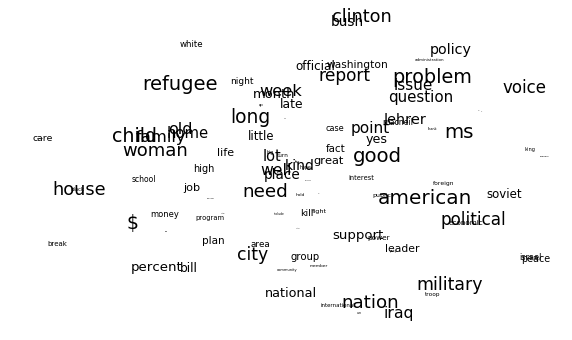

Period 1
[('return', 0.8685034513473511), ('rwanda', 0.8562815189361572), ('camp', 0.8514379262924194), ('hutu', 0.8434263467788696), ('hundred', 0.8423492908477783), ('flee', 0.8380054235458374), ('thousand', 0.8322793245315552), ('concentration', 0.8283401727676392), ('macedonia', 0.8244356513023376), ('albania', 0.823452353477478)]


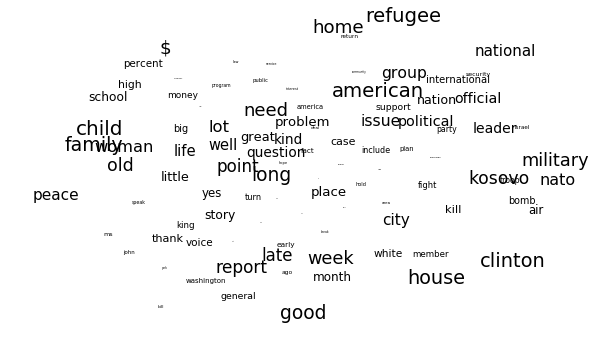

Period 2
[('orangutan', 0.8181745409965515), ('internment', 0.8037863969802856), ('resident', 0.7854429483413696), ('shamshatoo', 0.7806202173233032), ('phalangists', 0.7742987871170044), ('immigrant', 0.7737588882446289), ('displace', 0.7683157920837402), ('concentration', 0.768022894859314), ('afghans', 0.7532627582550049), ('ten', 0.7512896656990051)]


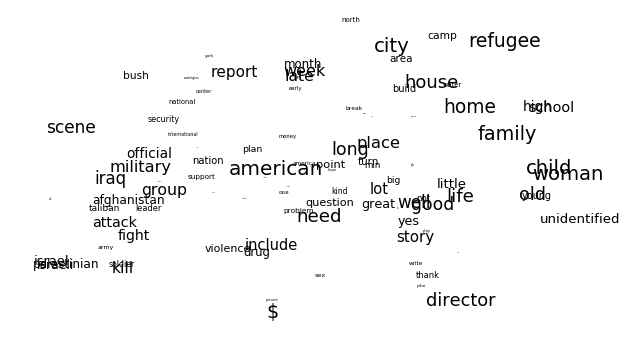

Period 3
[('camp', 0.9207609295845032), ('flee', 0.9076387286186218), ('thousand', 0.8896956443786621), ('return', 0.8739199638366699), ('hundred', 0.8205312490463257), ('population', 0.8110065460205078), ('displace', 0.8052156567573547), ('squalid', 0.8048092126846313), ('area', 0.8034710884094238), ('border', 0.8030716776847839)]


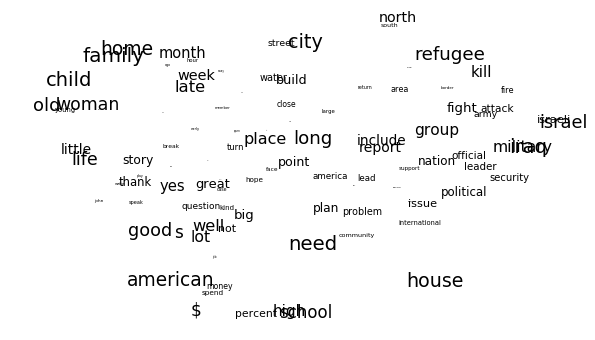

Period 4
[('migrant', 0.8654073476791382), ('camp', 0.8388972878456116), ('kilis', 0.8343473076820374), ('seeker', 0.8287910223007202), ('displace', 0.8208361864089966), ('asylum', 0.818926215171814), ('syrians', 0.8153116106987), ('stateless', 0.8051178455352783), ('travel', 0.8004144430160522), ('jordan', 0.796166718006134)]


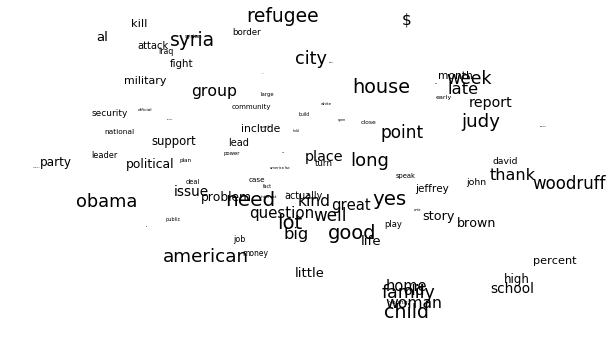

In [32]:
# By 5-year periods
period_w2v = {}
for p in periods:
    chunks = data[data['period']==p]
    data_w2v = gensim.models.word2vec.Word2Vec(chunks['normalized_sents'].sum())
    period_w2v[p] = data_w2v
    print("Period {}".format(p))
    print(data_w2v.most_similar(positive=['refugee']))
    plot_embeddings(data_w2v, 100, save=True, title='period_{}.png'.format(p))

In [33]:
period_w2v

{0: <gensim.models.word2vec.Word2Vec at 0x2b220af70>,
 1: <gensim.models.word2vec.Word2Vec at 0x1e72c4400>,
 2: <gensim.models.word2vec.Word2Vec at 0x1d071e2b0>,
 3: <gensim.models.word2vec.Word2Vec at 0x13d6d7490>,
 4: <gensim.models.word2vec.Word2Vec at 0x1e35e35b0>}

## 4. How are countries/identities associated with refugees over time?
* Countries: countrylist library
* Identities: citizenship (e.g. iraqi, chinese, etc.), religion, demographic (male, female, mother, father, child/children, etc.)
* Dimensions: legal-illegal, accept-ban, refugee-native


In [34]:
def normalize(vector):
    normalized_vector = vector / np.linalg.norm(vector)
    return normalized_vector

def dimension(model, positives, negatives):
    diff = sum([normalize(model[x]) for x in positives]) - sum([normalize(model[y]) for y in negatives])
    return diff

def makeDF(model, word_list, Dim1, Dim2, Dim3, dim1_label, dim2_label, dim3_label):
    dim1 = []
    dim2 = []
    dim3 = []
    for word in word_list:
        dim1.append(sklearn.metrics.pairwise.cosine_similarity(model[word].reshape(1,-1), Dim1.reshape(1,-1))[0][0])
        dim2.append(sklearn.metrics.pairwise.cosine_similarity(model[word].reshape(1,-1), Dim2.reshape(1,-1))[0][0])
        dim3.append(sklearn.metrics.pairwise.cosine_similarity(model[word].reshape(1,-1), Dim3.reshape(1,-1))[0][0])
    df = pd.DataFrame({dim1_label: dim1, dim2_label: dim2, dim3_label: dim3}, index = word_list)
    return df

def Coloring(Series):
    x = Series.values
    y = x-x.min()
    z = y/y.max()
    c = list(plt.cm.rainbow(z))
    return c

def PlotDimension(ax,df, dim):
    ax.set_frame_on(False)
    ax.set_title(dim, fontsize = 20)
    colors = Coloring(df[dim])
    for i, word in enumerate(df.index):
        ax.annotate(word, (0, df[dim][i]), color = colors[i], alpha = 0.6, fontsize = 12)
    MaxY = df[dim].max()
    MinY = df[dim].min()
    plt.ylim(MinY,MaxY)
    plt.yticks(())
    plt.xticks(())

In [35]:
def get_common_words():
    words = {}
    common = []

    for p in periods:
        vocab = list(period_w2v[p].wv.vocab.keys())
        for v in vocab:
            if v in words:
                words[v] += 1
            else:
                words[v] = 1
    for w, count in words.items():
        if count >= len(periods):
            # word in all periods
            common.append(w)
    return common

common = get_common_words()
len(common)

7938

#### Country Analysis

In [36]:
from country_list import countries_for_language
countries = dict(countries_for_language('en'))
countrylist = list(c.lower() for c in countries.values())
countrylist_all = countrylist + ['soviet', 'palestine']
countrylist_all

['afghanistan',
 'åland islands',
 'albania',
 'algeria',
 'american samoa',
 'andorra',
 'angola',
 'anguilla',
 'antarctica',
 'antigua & barbuda',
 'argentina',
 'armenia',
 'aruba',
 'ascension island',
 'australia',
 'austria',
 'azerbaijan',
 'bahamas',
 'bahrain',
 'bangladesh',
 'barbados',
 'belarus',
 'belgium',
 'belize',
 'benin',
 'bermuda',
 'bhutan',
 'bolivia',
 'bosnia & herzegovina',
 'botswana',
 'brazil',
 'british indian ocean territory',
 'british virgin islands',
 'brunei',
 'bulgaria',
 'burkina faso',
 'burundi',
 'cambodia',
 'cameroon',
 'canada',
 'canary islands',
 'cape verde',
 'caribbean netherlands',
 'cayman islands',
 'central african republic',
 'ceuta & melilla',
 'chad',
 'chile',
 'china',
 'christmas island',
 'cocos (keeling) islands',
 'colombia',
 'comoros',
 'congo - brazzaville',
 'congo - kinshasa',
 'cook islands',
 'costa rica',
 'côte d’ivoire',
 'croatia',
 'cuba',
 'curaçao',
 'cyprus',
 'czechia',
 'denmark',
 'diego garcia',
 'djibou

In [37]:
countries_w2v = []
for country in countrylist:
    if country in common:
        countries_w2v.append(country.lower())

In [78]:
# Word counts over periods
country_byperiod = {}
for p in periods:
    for word in data[data['period']==p]['tokenized_words'].sum():
        if word in countrylist_all:
            p=str(p)
            if p not in country_byperiod:
                country_byperiod[p] = {}
            if word not in country_byperiod[p]:
                country_byperiod[p][word] = 1
            else:
                country_byperiod[p][word] +=1

In [79]:
for p in periods:
    print("Period {}".format(p))
    print(country_byperiod[str(p)])
    print()

Period 0
{'cuba': 734, 'mexico': 282, 'georgia': 228, 'jordan': 675, 'france': 387, 'vietnam': 910, 'honduras': 33, 'peru': 55, 'haiti': 1123, 'china': 754, 'brazil': 91, 'bolivia': 15, 'ecuador': 16, 'germany': 1001, 'russia': 864, 'poland': 195, 'greece': 46, 'bulgaria': 34, 'romania': 61, 'albania': 67, 'hungary': 94, 'lithuania': 135, 'latvia': 31, 'estonia': 33, 'finland': 36, 'turkey': 357, 'soviet': 2329, 'austria': 56, 'kuwait': 1475, 'iraq': 2734, 'bangladesh': 56, 'india': 202, 'pakistan': 121, 'thailand': 96, 'philippines': 69, 'syria': 291, 'iran': 611, 'malawi': 17, 'mozambique': 76, 'israel': 2005, 'argentina': 34, 'ethiopia': 176, 'egypt': 274, 'grenada': 44, 'japan': 523, 'afghanistan': 102, 'chad': 7, 'angola': 64, 'kenya': 91, 'panama': 269, 'ukraine': 78, 'tunisia': 16, 'nicaragua': 85, 'guatemala': 63, 'cambodia': 334, 'taiwan': 109, 'singapore': 69, 'australia': 49, 'bermuda': 4, 'indonesia': 38, 'malaysia': 25, 'fiji': 5, 'spain': 106, 'jamaica': 22, 'uruguay': 16

In [152]:
country_byperiod_df = pd.DataFrame.from_dict(country_byperiod, orient='index')
country_byperiod_df.dropna(axis='columns', how='all', inplace=True)
country_byperiod_df

,cuba,mexico,georgia,jordan,france,vietnam,honduras,peru,haiti,china,...,montserrat,micronesia,nauru,tokelau,tuvalu,kyrgyzstan,anguilla,martinique,mayotte,andorra
0,734,282,228,675,387,910,33,55,1123,754,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,367,214,153,118,165,343,29,37,195,567,...,8.0,2.0,3.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
2,70,216,131,196,202,216,25,31,82,386,...,NaN,NaN,NaN,NaN,38.0,2.0,1.0,NaN,NaN,NaN
3,57,173,101,173,155,175,39,11,305,593,...,NaN,1.0,NaN,NaN,12.0,24.0,NaN,1.0,NaN,NaN
4,99,260,134,385,441,204,59,12,66,449,...,1.0,NaN,2.0,NaN,NaN,1.0,NaN,NaN,1.0,3.0


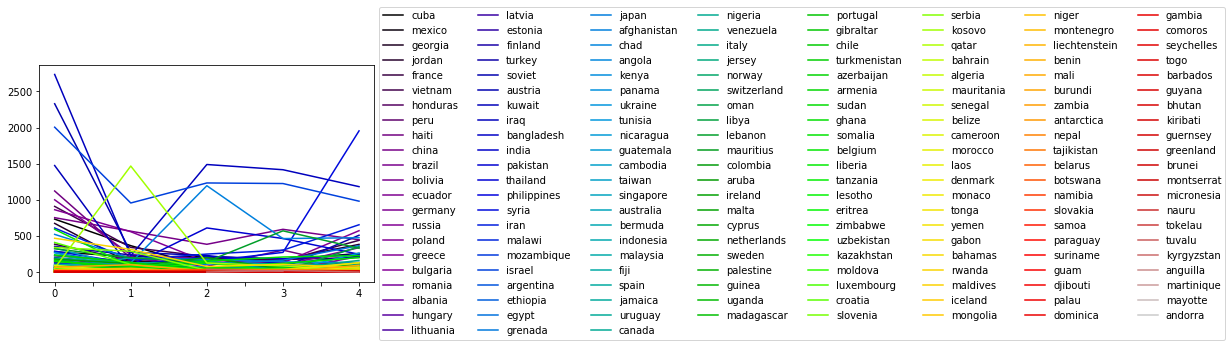

In [156]:
country_byperiod_df.plot(colormap='nipy_spectral')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),ncol=8)

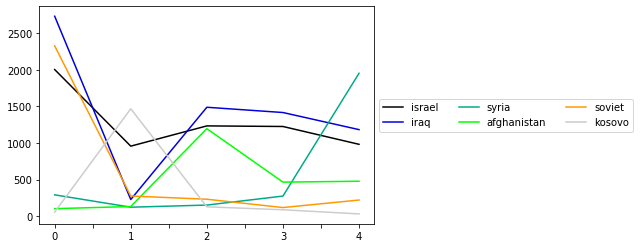

In [155]:
selected=['israel','iraq','syria','afghanistan','soviet','kosovo']
country_byperiod_df[selected].plot(colormap='nipy_spectral')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),ncol=3)

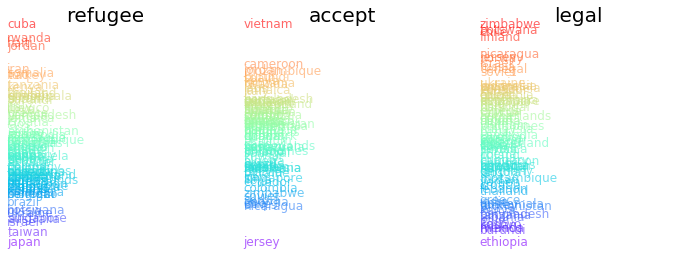

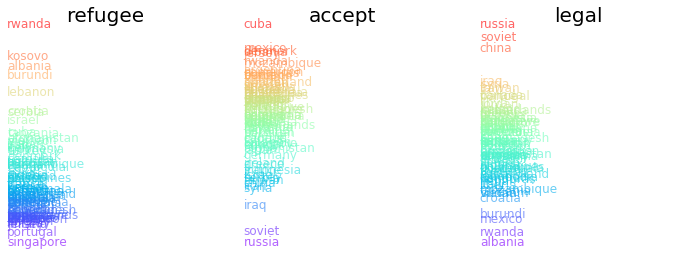

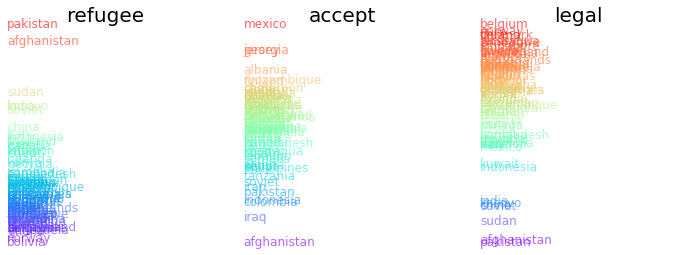

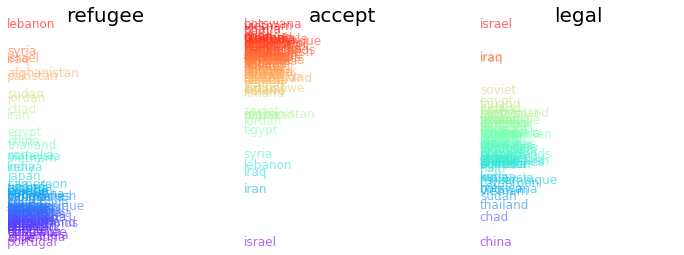

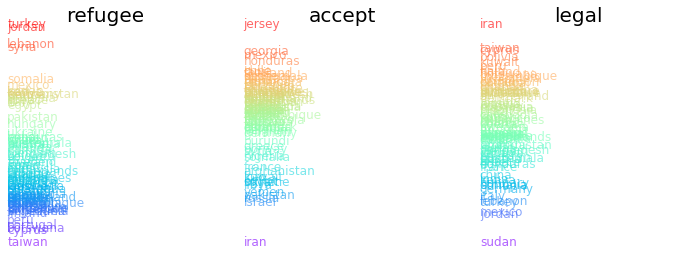

In [38]:
# W2V Dimensions for Countries
for p in periods:
    model = period_w2v[p]
    Refugee = dimension(model, ['refugee','flee'], ['native','remain'])
    Accept = dimension(model, ['welcome', 'accept'], ['ban','reject'])
    Legal = dimension(model, ['legal'], ['illegal'])
    countries_full = countries_w2v + ['soviet']
    df = makeDF(model, countries_full, Refugee, Accept, Legal, 'refugee', 'accept', 'legal') 
    fig = plt.figure(figsize = (12,4))
    ax1 = fig.add_subplot(131)
    PlotDimension(ax1, df, 'refugee')
    ax2 = fig.add_subplot(132)
    PlotDimension(ax2, df, 'accept')
    ax3 = fig.add_subplot(133)
    PlotDimension(ax3, df, 'legal')
    plt.show